In [6]:
!pip3 install ann_visualizer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import resample


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
uploaded = files.upload()

Saving mitbih_train.csv to mitbih_train.csv


**Arrhythmia Dataset**

Number of Samples: 109446
Number of Categories: 5
Sampling Frequency: 125Hz
Data Source: Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

*   N : Non-ecotic beats (normal beat)
*   S : Supraventricular ectopic beats
*   V : Ventricular ectopic beats
*   F : Fusion Beats
*   Q : Unknown Beats



In [4]:
train_data =  pd.read_csv("data/mitbih_train.csv", header=None)
test_data =  pd.read_csv("data/mitbih_test.csv", header=None)

xtrain = train_data.loc[:, train_data.columns !=187 ]
ytrain = train_data.iloc[:, 187].values

xtest = test_data.loc[:, test_data.columns !=187 ]
ytest = test_data.iloc[:, 187].values

# convert values of Y to categorals 
Ytest = tf.keras.utils.to_categorical(ytest)
Ytrain = tf.keras.utils.to_categorical(ytrain)

**Resampling data**

In [7]:
df_0 = (train_data[train_data[187]==0]).sample(n=20000, random_state=42)
df_1 = train_data[train_data[187]==1]
df_2 = train_data[train_data[187]==2]
df_3 = train_data[train_data[187]==3]
df_4 = train_data[train_data[187]==4]

df_1_upsample = resample(df_1,replace=True, n_samples=20000,random_state=123)
df_2_upsample = resample(df_2,replace=True, n_samples=20000,random_state=124)
df_3_upsample = resample(df_3,replace=True, n_samples=20000,random_state=125)
df_4_upsample = resample(df_4,replace=True, n_samples=20000,random_state=126)

train_df = pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
classes = train_df.groupby(187,group_keys=False).apply(lambda train_df: train_df.sample(1))

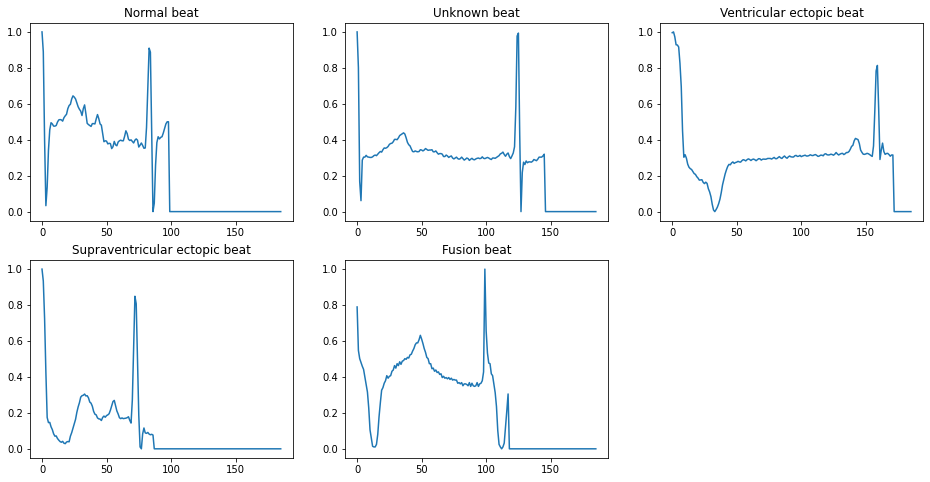

In [8]:
plt.figure(figsize=(16,8))
# NORMAL 
plt.subplot(2,3,1)
plt.plot(classes.iloc[0,:186])
plt.title("Normal beat")

# UNKNOWN
plt.subplot(2,3,2)
plt.plot(classes.iloc[1,:186])
plt.title("Unknown beat")

# VEB
plt.subplot(2,3,3)
plt.plot(classes.iloc[2,:186])
plt.title("Ventricular ectopic beat")

# SEB 
plt.subplot(2,3,4)
plt.plot(classes.iloc[3,:186])
plt.title("Supraventricular ectopic beat")

# FUSION 
plt.subplot(2,3,5)
plt.plot(classes.iloc[4,:186])
plt.title("Fusion beat")

plt.show()

In [9]:
# Fitting the classifier into the Training set
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

model_mrl_LogisticRegression = LogisticRegression()
model_mrl_LogisticRegression.fit(xtrain, ytrain)

model_mrl_RandomForestClassifier = RandomForestClassifier(n_estimators = 200)
model_mrl_RandomForestClassifier.fit(xtrain,ytrain)

model_mrl_HistGradientBoostingClassifier = HistGradientBoostingClassifier(max_bins=10, learning_rate=0.6)
model_mrl_HistGradientBoostingClassifier.fit(xtrain, ytrain)

model_mrl_XGBClassifier = XGBClassifier(learning_rate=0.2, max_depth=1, booster='dart', objective='binary:logistic')
model_mrl_XGBClassifier.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


XGBClassifier(booster='dart', learning_rate=0.2, max_depth=1,
              objective='multi:softprob')

**Evaluation Model for Classical Machine Learning Algorithm**

In [10]:
Y_Pred_LogisticRegression = model_mrl_LogisticRegression.predict(xtest)
Y_Pred_RandomForestClassifier = model_mrl_RandomForestClassifier.predict(xtest)
Y_Pred_HistGradientBoostingClassifier = model_mrl_HistGradientBoostingClassifier.predict(xtest)
Y_Pred_XGBClassifier = model_mrl_XGBClassifier.predict(xtest)

from sklearn.metrics import accuracy_score

print("Accuracy Logistic Regression: ", accuracy_score(ytest, Y_Pred_LogisticRegression) * 100)
print("Accuracy Random Forest Classifiery: ", accuracy_score(ytest, Y_Pred_RandomForestClassifier) * 100)
print("Accuracy Histogram-based Boosting Classifier: ", accuracy_score(ytest, Y_Pred_HistGradientBoostingClassifier) * 100)
print("Accuracy XGBoost Classifier: ", accuracy_score(ytest, Y_Pred_XGBClassifier) * 100)

Accuracy Logistic Regression:  91.16572263840672
Accuracy Random Forest Classifiery:  97.41001279006029
Accuracy Histogram-based Boosting Classifier:  93.99780741823497
Accuracy XGBoost Classifier:  92.89238077836653


In [15]:
from keras.regularizers import l2
# from keras_visualizer import visualizer 
from ann_visualizer.visualize import ann_viz

# 'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4

model = Sequential()
model.add(Dense(100,activation='relu', input_shape=(187,), kernel_regularizer=l2(0.2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary() 

ann_viz(model)

history = model.fit(xtrain, Ytrain, validation_data = (xtest, Ytest), epochs=300, verbose=2)

model.save("model.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               18800     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dense_7 (Dense)             (None, 5)                 105       
                                                                 
Total params: 24,975
Trainable params: 24,975
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
2737/2737 - 4s - loss: 0.8372 - accuracy: 0.8955 - val_loss: 0.3600 - val_accuracy: 0.9185 - 4s/epoch - 2ms/step
Epoch 2/300
2737/2737 - 4s - loss: 0.3575 - accuracy: 0.9

**Evaluation Model for Deep Neural Network**

In [16]:
print("Evaluation")
mse, acc = model.evaluate(xtest, Ytest)
print("Mean Equad Error :", mse)
print("accuracy :", acc)

Evaluation
685/685 [==============================] - 1s 944us/step - loss: 0.2578 - accuracy: 0.9434
Mean Equad Error : 0.2578006982803345
accuracy : 0.9434496760368347


Model Accuracy --- Model loss

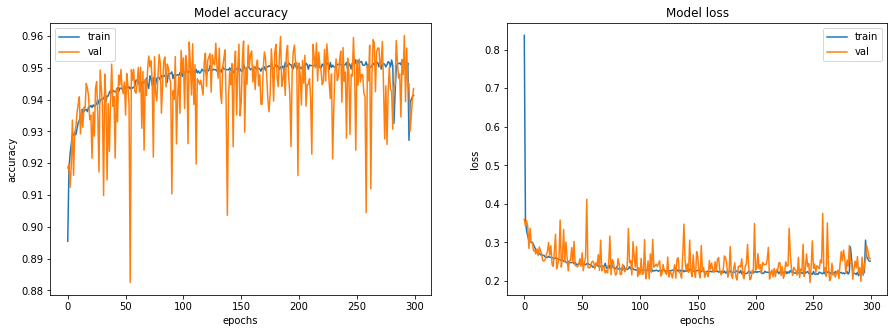

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
fog, ax = plt.subplots(1,2,figsize=(15,5))
for i, met in enumerate(['accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])
plt.show()

from google.colab import files
fog.savefig("model-accuracy-loss.png", dpi=300)
files.download("model-accuracy-loss.png") 